# Visualization of AdamMCMC

This notebook provides an interactive visualization of the optimization trajectories produced by AdamMCMC. Visualizing it in 2D and comparing it to stanard Adam helps build intuition for its behavior.

Inspired by: https://emiliendupont.github.io/2018/01/24/optimization-visualization/

In [1]:
from math import exp

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch
from scipy.stats import multivariate_normal

%matplotlib widget

Define the function to be optimized with its gradients, here
$$
f(x,y)
= -2\,\exp\!\left(-\frac{(x-1)^2 + y^2}{0.2}\right)
\;-\;3\,\exp\!\left(-\frac{(x+1)^2 + y^2}{0.2}\right)
\;+\;x^2 + y^2 .
$$

In [2]:
domain_x = (-2.0, 2.0)
domain_y = (-2.0, 2.0)
domain_f = (-3.0, 9.0)
contour_step = 0.2

def in_domain(x):
    x = np.asarray(x, dtype=float)
    return (domain_x[0] <= x[0] <= domain_x[1]) and (domain_y[0] <= x[1] <= domain_y[1])

def f_torch(x, y):
    return (
        -2.0 * torch.exp(-(((x - 1.0) ** 2 + y**2) / 0.2))
        -3.0 * torch.exp(-(((x + 1.0) ** 2 + y**2) / 0.2))
        + x**2
        + y**2
    )

def f(x, y):
    # Scalars -> float
    if np.isscalar(x) and np.isscalar(y):
        xt = torch.tensor(float(x))
        yt = torch.tensor(float(y))
        return float(f_torch(xt, yt).item())

    # Arrays -> numpy array
    x_arr = np.asarray(x, dtype=np.float64)
    y_arr = np.asarray(y, dtype=np.float64)
    xt = torch.from_numpy(x_arr)
    yt = torch.from_numpy(y_arr)
    with torch.no_grad():
        zt = f_torch(xt, yt)
    return zt.cpu().numpy()

def grad_f(x, y):
    xt = torch.tensor(float(x), requires_grad=True)
    yt = torch.tensor(float(y), requires_grad=True)
    z = f_torch(xt, yt)
    z.backward()
    return np.array([xt.grad.item(), yt.grad.item()], dtype=float)

In [3]:
from math import exp

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch
from scipy.stats import multivariate_normal

%matplotlib widget

Set Adam hyperparameters, a number of burn in steps can be defined here

In [4]:
# orig
learning_rate = 1e-2
num_steps = 100
burnin = 0
beta_1 = 0.7
beta_2 = 0.999
eps = 1e-6

In [5]:
# MCMC
learning_rate = 1e-2
num_steps = 200
burnin = 0
beta_1 = 0.9
beta_2 = 0.9
eps = 1e-8

Standard Adam optimizer implementation

In [6]:
def get_adam_path(x0, y0, sigma=None, sigma_g=None):
    m = np.zeros(2, dtype=float)
    v = np.zeros(2, dtype=float)
    path = np.zeros((num_steps + burnin + 1, 2), dtype=float)
    path[0] = [x0, y0]

    x = np.array([x0, y0], dtype=float)
    for t in range(num_steps + burnin):
        g = grad_f(x[0], x[1])
        m = beta_1 * m + (1.0 - beta_1) * g
        v = beta_2 * v + (1.0 - beta_2) * (g * g)
        x = x - learning_rate * m / (np.sqrt(v) + eps)
        path[t + 1] = x
    return path

AdamMCMC as implemented in [Bieringer et al. (2024)](https://arxiv.org/abs/2312.14027)

In [7]:
lam = 1
sigma = 0.1
sigma_g = 1.0

def get_u(t, m_1, m_2):
    m_1 = m_1 / (1 - beta_1**(t + 1))
    m_2 = m_2 / (1 - beta_2**(t + 1))
    return learning_rate * m_1 / (np.sqrt(m_2) + eps)

def get_covar(u, sigma, sigma_g):
    u = u[None, :]
    return sigma * sigma * np.eye(2) + sigma_g * sigma_g * u.T @ u

In [8]:
def get_adammcmc_path(x0, y0, sigma=sigma, sigma_g=sigma_g):
    m_1 = np.zeros(2, dtype=float)
    m_2 = np.zeros(2, dtype=float)
    path = np.zeros((num_steps + burnin + 1, 2), dtype=float)
    path[0] = [x0, y0]

    theta = np.array([x0, y0], dtype=float)
    for t in range(num_steps + burnin):
        g = grad_f(theta[0], theta[1])
        m_1 = beta_1 * m_1 + (1.0 - beta_1) * g
        m_2 = beta_2 * m_2 + (1.0 - beta_2) * (g * g)
        u = get_u(t, m_1, m_2)

        theta_tilde = theta - u
        covar = get_covar(u, sigma, sigma_g)
        tau = np.random.multivariate_normal(theta_tilde, covar)
        tau_tilde = tau - u

        if in_domain(tau):
            A = exp(-lam * f(tau[0], tau[1])) / exp(-lam * f(theta[0], theta[1]))
            B = multivariate_normal.pdf(theta, mean=tau_tilde, cov=covar) / multivariate_normal.pdf(tau, mean=theta_tilde, cov=covar)
            alpha = A * B

            if alpha >= np.random.uniform(0.0, 1.0):
                theta = tau
                
        path[t + 1] = theta
    return path

Variation of AdamMCMC without assumptions on the reverse step, which is calculated as if it being the next step

In [9]:
def get_adammcmcstar_path(x0, y0, sigma=sigma, sigma_g=sigma_g):
    m_1 = np.zeros(2, dtype=float)
    m_2 = np.zeros(2, dtype=float)
    path = np.zeros((num_steps + burnin + 1, 2), dtype=float)
    path[0] = [x0, y0]

    theta = np.array([x0, y0], dtype=float)
    for t in range(num_steps + burnin):
        g = grad_f(theta[0], theta[1])
        m_1 = beta_1 * m_1 + (1.0 - beta_1) * g
        m_2 = beta_2 * m_2 + (1.0 - beta_2) * (g * g)
        u_theta = get_u(t, m_1, m_2)
        mean_theta = theta - u_theta
        covar_theta = get_covar(u_theta, sigma, sigma_g)

        tau = np.random.multivariate_normal(mean_theta, covar_theta)

        if in_domain(tau):
            g = grad_f(tau[0], tau[1])
            m_1_ = beta_1 * m_1 + (1.0 - beta_1) * g
            m_2_ = beta_2 * m_2 + (1.0 - beta_2) * (g * g)
            u_tau = get_u(t + 1, m_1_, m_2_)
            mean_tau = tau - u_tau
            covar_tau = get_covar(u_tau, sigma, sigma_g)
            
            A = exp(-lam * f(tau[0], tau[1])) / exp(-lam * f(theta[0], theta[1]))
            B = multivariate_normal.pdf(theta, mean=mean_tau, cov=covar_tau) / multivariate_normal.pdf(tau, mean=mean_theta, cov=covar_theta)
            alpha = A * B

            if alpha >= np.random.uniform(0.0, 1.0):
                theta = tau
                
        path[t + 1] = theta
    return path

Visualization of standard Adam, five AdamMCMC instantiations, and reverse step AdamMCMC

Burn in phase is not shown

Start by clicking somewhere on the canvas

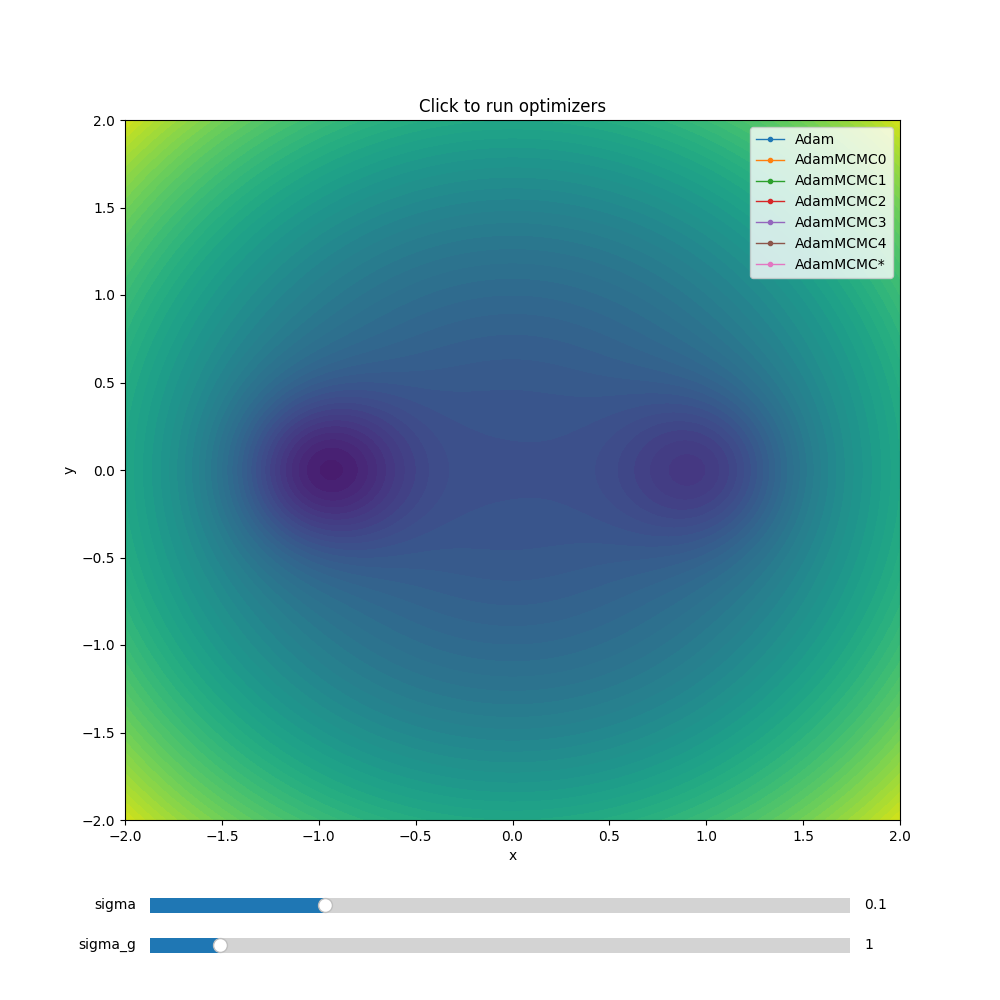

In [10]:
nx, ny = 192, 100
xs = np.linspace(domain_x[0], domain_x[1], nx)
ys = np.linspace(domain_y[0], domain_y[1], ny)
X, Y = np.meshgrid(xs, ys)
Z = f(X, Y)

levels = np.arange(domain_f[0], domain_f[1], contour_step)

fig, ax = plt.subplots(figsize=(10, 10))
fig.subplots_adjust(bottom=0.18)  # make room for sliders

ax.contourf(X, Y, Z, levels=levels)
ax.set_xlim(domain_x)
ax.set_ylim(domain_y)
ax.set_title("Click to run optimizers")
ax.set_xlabel("x")
ax.set_ylabel("y")

# --- sliders ---
ax_sigma   = fig.add_axes([0.15, 0.08, 0.70, 0.03])
ax_sigma_g = fig.add_axes([0.15, 0.04, 0.70, 0.03])

s_sigma = Slider(ax_sigma, "sigma", 0.0, 0.4, valinit=sigma, valstep=0.001)
s_sigma_g = Slider(ax_sigma_g, "sigma_g", 0.0, 10.0, valinit=sigma_g, valstep=0.1)

# Register any number of path functions here:
# IMPORTANT: these functions must accept sigma and sigma_g as keyword args (or **kwargs),
# e.g. def get_adammcmc_path(x0, y0, sigma=..., sigma_g=..., ...): ...
PATH_FNS = {
    "Adam": get_adam_path,
    "AdamMCMC0": get_adammcmc_path,
    "AdamMCMC1": get_adammcmc_path,
    "AdamMCMC2": get_adammcmc_path,
    "AdamMCMC3": get_adammcmc_path,
    "AdamMCMC4": get_adammcmc_path,
    "AdamMCMC*": get_adammcmcstar_path,
}

# One line+marker-per-step per optimizer
paths_artists = {}
for name in PATH_FNS:
    (artist,) = ax.plot(
        [],
        [],
        linewidth=1,
        marker="o",
        markersize=3,
        label=name,
    )
    paths_artists[name] = artist

ax.legend(loc="upper right", framealpha=0.8)

_last_click = None  # (x0, y0)

def run_paths(x0, y0):
    sigma = float(s_sigma.val)
    sigma_g = float(s_sigma_g.val)

    for name, fn in PATH_FNS.items():
        # assumes fn supports sigma/sigma_g (or accepts **kwargs)
        path = fn(x0, y0, sigma=sigma, sigma_g=sigma_g)
        paths_artists[name].set_data(path[burnin:, 0], path[burnin:, 1])

def on_click(event):
    global _last_click
    if event.inaxes != ax or event.xdata is None or event.ydata is None:
        return
    _last_click = (event.xdata, event.ydata)
    run_paths(*_last_click)
    fig.canvas.draw_idle()

cid = fig.canvas.mpl_connect("button_press_event", on_click)
plt.show()
